In [1]:
from quantumsim.functions.ansatz import *
from quantumsim.functions.min_methods import *
from quantumsim.functions.funciones import *
from quantumsim.optimizacion_structure import *
from quantumsim.variational_quantum_eigensolver import *

from pennylane import numpy as np
import matplotlib.pyplot as plt


def molecular_energies(symbols, coordinates, basis_set):
    charge = 0
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

# Molecula de $H^2$
En este jupyter vamos a poder a prueba los metodos implementados, aca solo se considerara como base el dimero de hidrogeno.

Primero se probara el VQE, luego el VQD y finalmente se haran un par de pruebas en el VQT.

En el VQE y VQD se probaran los diferentes basis set con diferente numero de dimeros

## VQE: un dimero

### Basis set sto-3g

In [7]:
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614], requires_grad=True)

#Parametros del hamiltoniano molecular
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    #'basis': 'sto-3g',
    'basis': '6-31g',
    'method': 'dhf'
}

#Construccion de la clase
molecule = vqe_molecular(symbols, coordinates, params)
molecule.set_group_characteristics()

In [8]:
ansatz_params = {
    "repetitions": 3,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
    "pattern": "chain"
}

# Seteo de hiperparametros del circuito
molecule.set_device( ansatz_params )
molecule.set_node( ansatz_params )

rep = molecule.qubits*ansatz_params["repetitions"]

In [10]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 100,
    "tol": 0.000001,
    "step_theta":0.3,
    "step_x":0.7,
    "number": molecule.qubits*ansatz_params["repetitions"]}

# Ejecucion del optimizador para calcular los niveles 
# de energia

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()

energy, optimum = optimizer.VQE(molecule.cost_function, molecule.qubits)

[0, 1, 0, 1, 0, 1, 0, 1]


/Users/jnorambu/Documents/vqesimulation/env/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


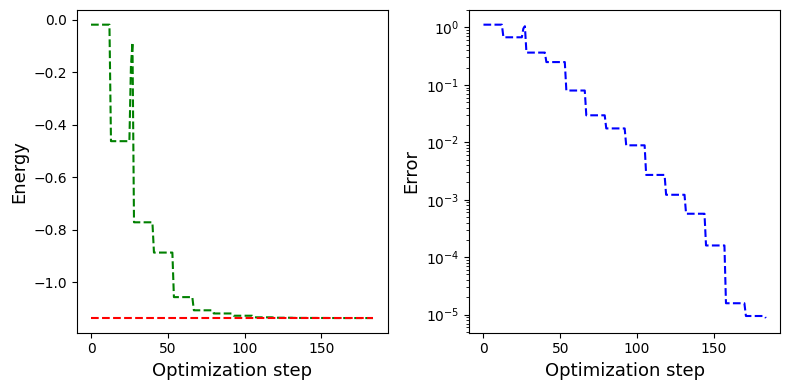

In [6]:
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

ax[0].plot([i for i in range(len(energy))], energy, "g", ls="dashed")
ax[0].plot([i for i in range(len(energy))], [ee[0] for i in range(len(energy))], "r", ls="dashed")

ax[1].plot([i for i in range(len(energy))], [np.abs(energy[i] -ee[0]) for i in range(len(energy))], "b", ls="dashed")
ax[1].set_yscale("log")
fig.tight_layout()
plt.show()

## VQE: Dos dimeros

In [7]:
symbols = ["H", "H", "H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614, 0.0, 1.0, -0.6614, 0.0, 1.0, 0.6614], requires_grad=True)

#Parametros del hamiltoniano molecular
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf'
}

#Construccion de la clase
molecule = vqe_molecular(symbols, coordinates, params)
molecule.set_group_characteristics()

In [8]:
ansatz_params = {
    "repetitions": 2,
    "base": "default.qubit",
    "pattern": "",
    "backend": None,
    "interface": "autograd",
    "shots": 2**10,
    "token": None,
}

# Seteo de hiperparametros del circuito
molecule.set_device( ansatz_params )
molecule.set_node( ansatz_params )

rep = molecule.qubits*ansatz_params["repetitions"]

In [4]:
minimizate_params = {
    "type": "SLSQP",
    "maxiter": 200,
    "tol": 0.000001,
    "number": molecule.qubits*ansatz_params["repetitions"]}

optimizer = scipy_optimizer(minimizate_params)
optimizer.set_constrains()

energy, optimum = optimizer.VQE(molecule.cost_function, molecule.qubits)

[0, 1, 0, 1, 0, 1, 0, 1]


In [11]:
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

print(energy[-1], min(energy))
print(ee)

/Users/jnorambu/Documents/vqesimulation/env/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


-1.1261214629131187 -1.1261214629131187
[-1.15015652 -0.90214058 -0.90214058 -0.73210246 -0.73210246 -0.73210246
 -0.57496493 -0.54501365 -0.54501365 -0.4573917  -0.4573917  -0.40656487
 -0.40656487 -0.30155458 -0.30155458 -0.30155458 -0.29116099 -0.14216493
 -0.14216493 -0.14216493 -0.14216493 -0.10837638 -0.02759726 -0.02759726
  0.0144269   0.11888473  0.11888473  0.16377376  0.16377376  0.16377376
  0.16409712  0.16409712  0.22755196  0.27390298  0.27390298  0.27390298
  0.29873517  0.29873517  0.31199174  0.3470265   0.3470265   0.3470265
  0.4552315   0.4552315   0.4552315   0.4552315   0.48030427  0.48030427
  0.48803866  0.48803866  0.48803866  0.52317769  0.52317769  0.5777653
  0.5777653   0.64804208  0.66256352  0.66256352  0.69633705  0.75597218
  0.79397114  0.81107038  0.81844135  0.81844135  0.83791976  0.83791976
  0.83791976  0.86820405  0.86820405  0.86820405  0.9191889   0.9191889
  0.9191889   0.9191889   0.95013255  0.95013255  0.95885311  1.02158711
  1.02158711  

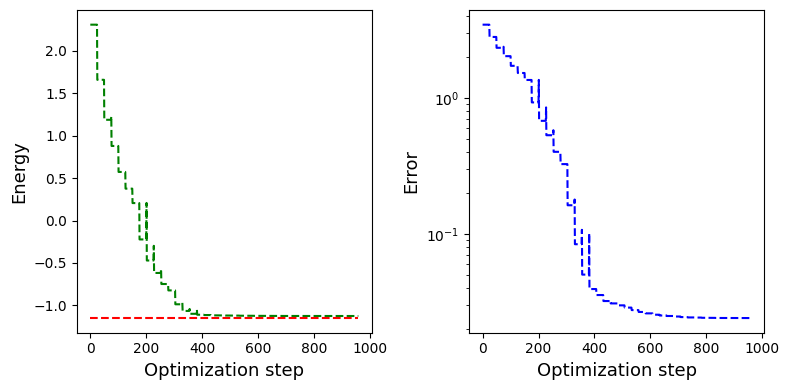

In [12]:
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

ax[0].plot([i for i in range(len(energy))], energy, "g", ls="dashed")
ax[0].plot([i for i in range(len(energy))], [ee[0] for i in range(len(energy))], "r", ls="dashed")

ax[1].plot([i for i in range(len(energy))], [np.abs(energy[i] -ee[0]) for i in range(len(energy))], "b", ls="dashed")
ax[1].set_yscale("log")
fig.tight_layout()
plt.show()

## VQE: Tres dimeros

In [17]:
symbols = ["H", "H", "H", "H", "H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614, 
        0.0, 1.0, -0.6614, 0.0, 1.0, 0.6614,
        0.0, 2.0, -0.6614, 0.0, 2.0, 0.6614], requires_grad=True)

#Parametros del hamiltoniano molecular
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf'
}

#Construccion de la clase
molecule = vqe_molecular(symbols, coordinates, params)
molecule.set_group_characteristics()

In [18]:
ansatz_params = {
    "repetitions": 2,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 2**10,
    "token": None,
}

# Seteo de hiperparametros del circuito
molecule.set_device( ansatz_params )
molecule.set_node( ansatz_params )

rep = molecule.qubits*ansatz_params["repetitions"]

In [19]:
minimizate_params = {
    "maxiter": 100,
    "tol": 0.000001,
    "step_theta":0.4,
    "step_x":0.8,
    "number": molecule.qubits*ansatz_params["repetitions"]}

# Ejecucion del optimizador para calcular los niveles 
# de energia

optimizer = gradiend_optimizer(minimizate_params)
#optimizer.set_constrains()

energy, optimum = optimizer.VQE(molecule.cost_function, molecule.qubits)

[1 1 1 1 1 1 0 0 0 0 0 0]


KeyboardInterrupt: 

In [ ]:
ee = molecular_energies(symbols=symbols, coordinates=coordinates, basis_set=params["basis"])

fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Optimization step", fontsize=13)
ax[0].set_ylabel("Energy", fontsize=13)

ax[1].set_xlabel("Optimization step", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

fig.suptitle('Ground state of a spin chain', fontsize=12)

ax[0].plot([i for i in range(len(energy))], energy, "g", ls="dashed")
ax[0].plot([i for i in range(len(energy))], [ee[0] for i in range(len(energy))], "r", ls="dashed")

ax[1].plot([i for i in range(len(energy))], [np.abs(energy[i] -ee[0]) for i in range(len(energy))], "b", ls="dashed")
ax[1].set_yscale("log")
fig.tight_layout()
plt.show()

## VQE: Cuatro dimeros

In [9]:
symbols4 = ["H", "H", "H", "H", "H", "H", "H", "H"]
coordinates4 = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614, 
        0.0, 1.0, -0.6614, 0.0, 1.0, 0.6614,
        0.0, 2.0, -0.6614, 0.0, 2.0, 0.6614,
        0.0, 3.0, -0.6614, 0.0, 3.0, 0.6614], requires_grad=True)


#Parametros del hamiltoniano molecular
params4 = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf'
}

#Construccion de la clase
molecule4 = vqe_molecular(symbols4, coordinates4, params4)
molecule4.set_group_characteristics()

In [11]:
ee = molecular_energies(symbols=symbols4, coordinates=coordinates4, basis_set=params4["basis"])

/Users/jnorambu/Documents/vqesimulation/env/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


: 

: 

In [ ]:
ansatz_params = {
    "repetitions": 2,
    "base": "default.qubit",
    "backend": None,
    "interface": "autograd",
    "shots": 1000.0,
    "token": None,
}

# Seteo de hiperparametros del circuito
molecule.set_device( ansatz_params )
molecule.set_node( ansatz_params )

rep = molecule.qubits*ansatz_params["repetitions"]